# Classification of plants diseases

### Table of Contents:

I. <a href='#intro'>Introduction</a>

II. <a href='#data'>Data Description and Visualization</a>

III. <a href='#arch'>Architecture</a>

IV. <a href='#train'>Training and Testing</a>

V. <a href='#results'>Results and Conclusion</a>


### I. Introduction <a id='intro'></a>

In this project we aim to use deep convolutional networks for image classification to identify 26 plants diseases in 14 different crop species, having a total of 38 classes of pairwise crops and diseases. We also aim to go beyond image classification and investigate the role of the background on the training of the model and the model performance. The aim is to understand whether the CNN learns the idea of the plant diseases or if it is just learning the inherent biases in the dataset.

The motivation behind choosing CNN is that it's a very specialized kind of neural network for processing data that has a known grid-like topology, so it is one of the best neural networks used for image classification. There are very important advantages of CNNs; sparse interactions or sparse connectivity, that allows the network to capture the cruical small features using kernels and leaving out the other unimportant pixels, which saves memory and improves the network statistical efficiency.[1] In images we would be able to extract the important features like edges and patterns. Parameter sharing is also a very important feature of this neural network; the fact the weights are used more than once and are not only tied to one neuron like in traditional neural networks. This brings down the number of parameters to be estimated by a huge amount, which in turn increases the model efficiency and use less memory.

We created two CNN architectures, we start off by a rather simple model and then build on that to have a better performing model. We will train both our models on three different variations of the dataset, the original dataset; which consists of colored images of the leaves, a gray-scaled version, and a Segmented version; where the extra background information is removed. We will also experiment with different decay rates and we will show how much the decay rate can affect the model learning process. The experimental results on the first developed model achieved accuracy, on a held-out test set, of 88% for the coloured dataset 76% for the gray-scaled, and 80% for the Segmented. As for the second model, it achieved 93% accuracy for the coloured dataset 76% for the gray-scaled, and 86% for the Segmented.


### II. Data Description and Visualization <a id='data'></a>

**Dataset**

The original version of the dataset (colored) used in the analysis is from the PlantVillage dataset and the two other versions are a transformation of the original dataset. All the datasets are obtained from SP Mohanty github repository(https://github.com/spMohanty/PlantVillage-Dataset). The dataset contains 54,306 images of plant leaves, and has 26 diseases in total for 14 different crop species and a total of 38 classes of crop-disease pairs, including the healthy pair and all the pairs are well represented in the dataset. Examples of the species included in the dataset are Apple, Blueberry, Cherry, and Orange and examples of diseases are Apple Scab, Bacterial rot, and Early Blight.

**Image Preprocessing and augmentation**

For all the three versions of the dataset, the images were rescaled to 256 × 256 pixels, and the model training and predictions were performed on these downscaled images. Also, the Image data generator class from Keras was used to augment the data and increase its size. This is a very common approach to reduce overfitting, new batches of the data are created given different transformations of the original data, it is computationally free and doesn't need to be stored on disk as the data is looped over in the training time. Image translations including width and height shifting of 1% of the total width/height of image, rotation with range of 25 degrees,horizontal flipping, and random zooming in and out on the image, 0.2 was chosen which means that the range for zooming will be from 80% (zoom in) to 120% (zoom out) and shear range of 0.2.

 

In [1]:
#all imports
import os
import sys
import time
import re
import datetime as dt

import warnings
warnings.filterwarnings("ignore")

import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, PReLU
from keras.optimizers import SGD, RMSprop, Adam
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.preprocessing import image
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import numpy
import pandas as pd
import seaborn as sns
import tqdm

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid

plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16

sns.set_palette('muted',color_codes=True)
sns.set_context('notebook', font_scale=1.4)
vc_color = '#B5C9EB'

import pickle
import cv2
from cv2 import IMREAD_GRAYSCALE
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
#reading in the datasets from github repo
!git clone https://github.com/spMohanty/PlantVillage-Dataset

Cloning into 'PlantVillage-Dataset'...
remote: Enumerating objects: 163229, done.
remote: Total 163229 (delta 0), reused 0 (delta 0), pack-reused 163229
Receiving objects: 100% (163229/163229), 2.00 GiB | 40.80 MiB/s, done.
Resolving deltas: 100% (99/99), done.
Checking out files: 100% (182401/182401), done.


**Visualization**

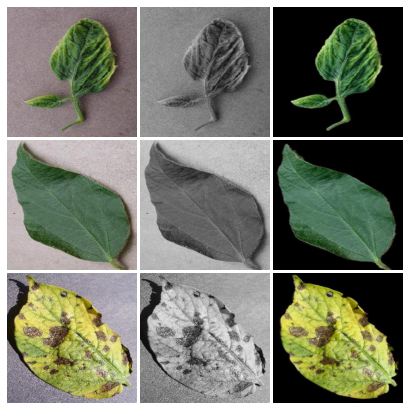

In [0]:
#Plotting same image from the different versions of the dataset
data_dir = './PlantVillage-Dataset/raw/'

fig = plt.figure(1, figsize=(6, 6))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 3), axes_pad=0.05)

np.random.seed(30)
rnd = np.random.randint(0, len(db), 3)
image_types = ["color", "grayscale", "segmented"]
i = 0
for r in rnd:
    file = db.file[r]
    for t in image_types:
        filepath = data_dir + t + "/" + file
        if t == "segmented":
            filepath = filepath.replace(".JPG", "") + "_final_masked.jpg"
            
        ax = grid[i]
        img = image.load_img(filepath, target_size=(256, 256))
        img = image.img_to_array(img)
        ax.imshow(img / 255.)
        ax.axis('off')
        i += 1
plt.tight_layout()


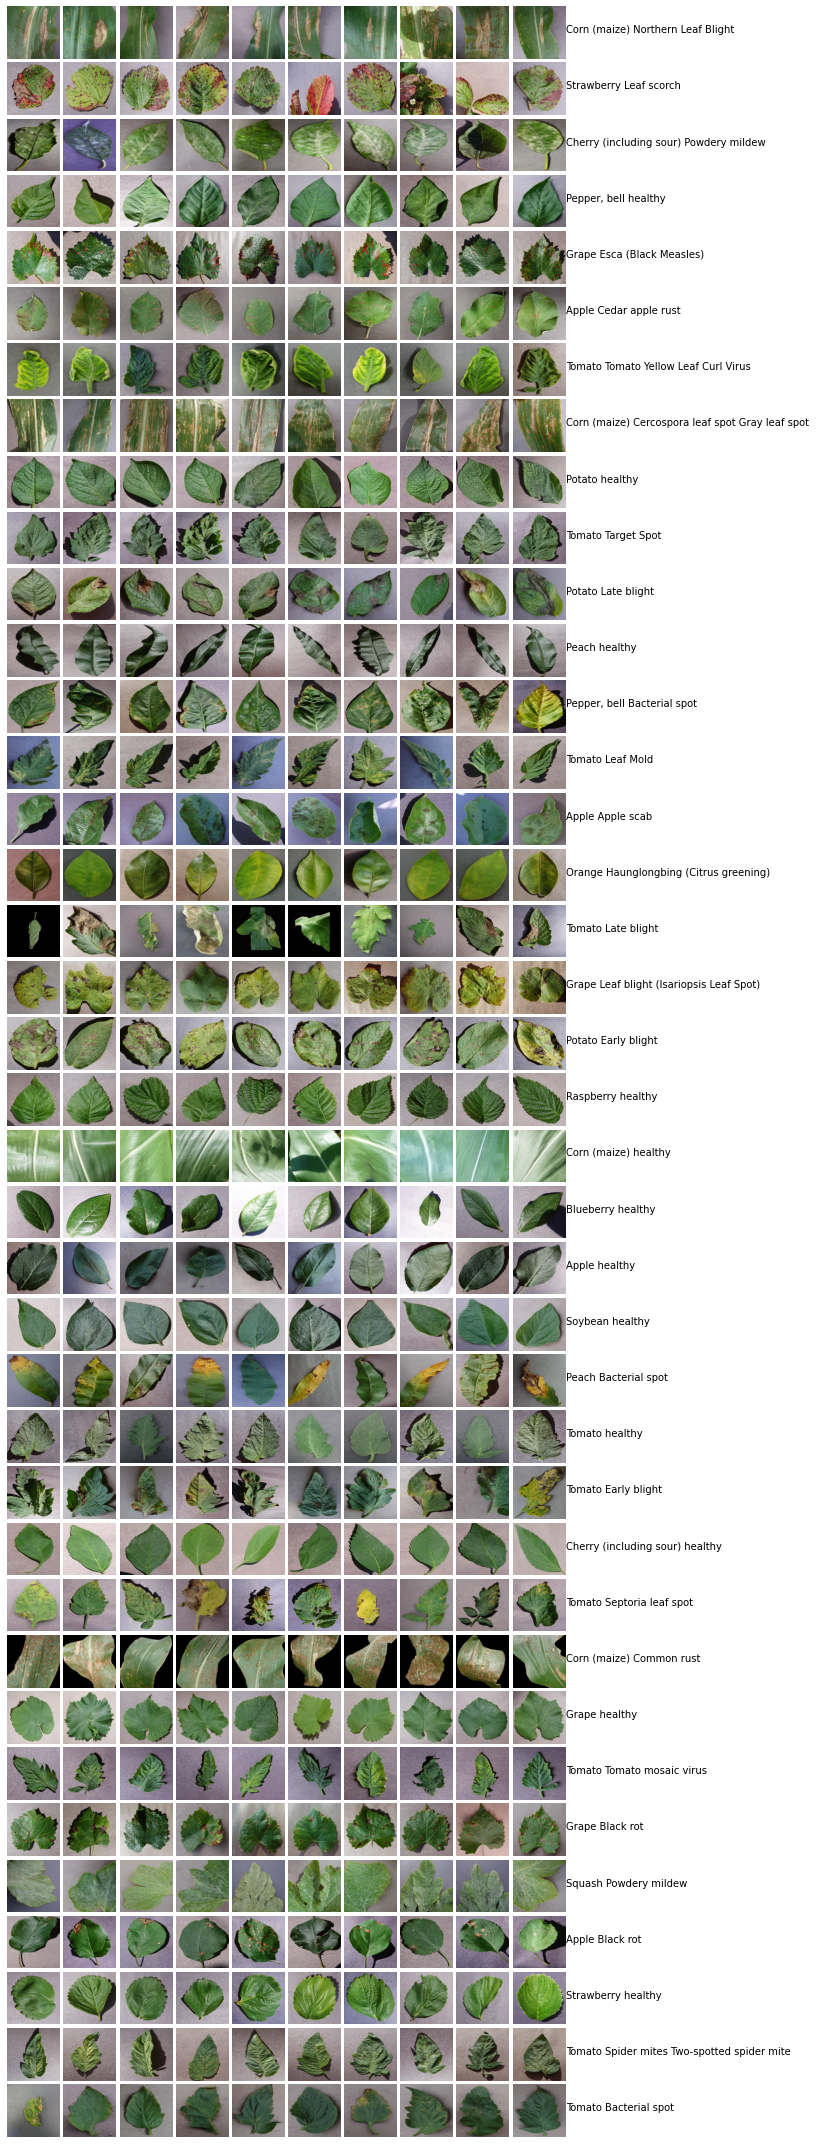

In [0]:
#plotting all disease-species combinations
# Path variables
data_dir_col = './PlantVillage-Dataset/raw/color' 

# Get list of all classes
classes = os.listdir(data_dir_col)
set(classes)

# List of species
species = set()
for c in classes:
    s = re.findall(".+?___", c)[0][:-3]
    species.add(s)
    
#list of diseases
diseases = set()
for c in classes:
    d = re.findall("___.+", c)[0][3:]
    diseases.add(d)

def read_img(filepath, size):
    img = image.load_img(data_dir_col + '/' +filepath, target_size=size)
    img = image.img_to_array(img)
    return img

def format_name(s):
    return re.sub('_+', ' ', s)
# Get path and label for each training image
db=[]
for label, class_name in enumerate(classes):
    path = data_dir_col +'/'+ class_name
    for file in os.listdir(path):
        if not '.ini' in file:
            db.append(['{}/{}'.format(class_name, file), label, class_name])
db = pd.DataFrame(db, columns=['file', 'label', 'class_name'])

# Plot some images (fixed dimensions)
num_classes = len(classes)
fig = plt.figure(1, figsize=(10, 40))
grid = ImageGrid(fig, 111, nrows_ncols=(num_classes, 10), axes_pad=0.05)

i = 0
for label, class_name in enumerate(classes):
    for filepath in db[db['class_name'] == class_name]['file'].values[:10]:
        ax = grid[i]
        img = read_img(filepath, (256, 256))
        ax.imshow(img / 255.)
        ax.axis('off')
        if i % 10 == 10 - 1:
            name = format_name(filepath.split('/')[0])
            ax.text(260, 112, name , verticalalignment='center')
        i += 1
plt.title('Sample images for each class. fig(2)')           
plt.show();

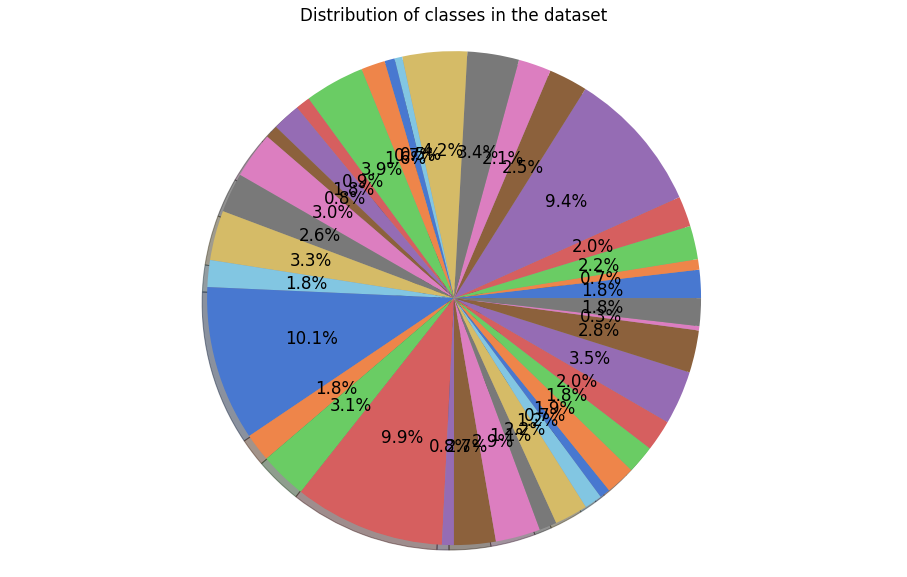

<Figure size 360x360 with 0 Axes>

In [0]:
#Plotting the percentage of images in each class
image_counts = {}
for c in classes:
    path = data_dir_col + '/' + c
    count = len(os.listdir(path))
    image_counts[c] = count

fig1, ax1 = plt.subplots()
ax1.pie([float(v) for v in image_counts.values()],  autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
plt.title('Distribution of classes in the dataset')
ax1 = plt.figure(figsize=(5,5))
plt.show()


**Parameters**

In [0]:
#Setting all required parameters
EPOCHS = 100
INIT_LR = 0.001
BS = 32
default_image_size = tuple((256, 256))
width=256
height=256
depth_col=3
depth_BW=1
# Path variables
data_dir_col = './PlantVillage-Dataset/raw/color/' 
data_dir_BW = './PlantVillage-Dataset/raw/grayscale/' 
data_dir_seg = './PlantVillage-Dataset/raw/segmented/' 

**Functions**

In [0]:
#define function for converting image to array
def image_to_array(image_dir, code):
  """Reads in an image and convert it to an array"""
  if code == 1: #gives it channel 1
    image = cv2.imread(image_dir, cv2.IMREAD_GRAYSCALE)
  else:
    image = cv2.imread(image_dir) #gives it channel 3
  if image is not None :
    image = cv2.resize(image, default_image_size)
    return img_to_array(image)
  else :
    return np.array([]) 

#define function for getting training, testing, and validation data
def get_img_label(data_dir, index, code):
  """Gets the required images from the respective directory where the images 
  reside and concerts them to arrays and
  get the labels and save them in another list"""
  image_lst, label_lst = [], []
  root_dir = listdir(data_dir)
  for plant_disease_folder in root_dir :
    plant_disease_folder_list = listdir(f"{data_dir}/{plant_disease_folder}")
    if index > 0: #if index is positive, get the training and validation data, else extract testing data
      for image in plant_disease_folder_list[:index]:
        image_directory = f"{data_dir}/{plant_disease_folder}/{image}"
        if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
          image_lst.append(image_to_array(image_directory, code))
          label_lst.append(plant_disease_folder)
    else:
      for image in plant_disease_folder_list[index:]:
        image_directory = f"{data_dir}/{plant_disease_folder}/{image}"
        if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
          image_lst.append(image_to_array(image_directory, code))
          label_lst.append(plant_disease_folder)
  np_image_lst = np.array(image_lst, dtype=np.float16) / 225.0
  return np_image_lst, label_lst

#Transforming image labels function
def transform_labels(label_list):
  """converts multi-class labels to binary labels using labelBinarizer"""
  label_binarizer = LabelBinarizer()
  image_labels = label_binarizer.fit_transform(label_list)
  return image_labels, label_binarizer

#plotting functions
def plot_accuracy(history):
  """plots the testing and validation accuracy"""
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  plt.figure(figsize=(6,6))
  plt.plot(epochs, acc, 'b', label='Training accurarcy')
  plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
  plt.title('Training and Validation accurarcy')
  plt.legend()
  plt.show()

def plot_loss(history):
  """plots the testing and validation loss"""
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)
  plt.figure(figsize=(6,6))
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and Validation loss')
  plt.legend()
  plt.show()
  
#Evaluation metrics functions
def get_classification_report(model, label_binarizer, x_test, y_test):
  """Returns the classification report for a given model"""
  model_pred = model.predict(x_test, verbose=1)
  y_true, y_pred = [], []
  classes = label_binarizer.classes_
  for idx, prediction in enumerate(model_pred):
    y_true.append(classes[np.argmax(y_test[idx])])
    y_pred.append(classes[np.argmax(prediction)])
  print(classification_report(y_pred, y_true))

def get_confusion_matrix(model, label_binarizer, x_test, y_test):
  """Returns the confusion matrix given testing a model"""
  y_pred = model.predict(x_test)
  y_pred = np.argmax(y_pred, axis = 1)
  modified_ytest = np.argmax(y_test, axis =1)
  labels = list(label_binarizer.classes_)
  conf_mat = multilabel_confusion_matrix(modified_ytest, y_pred, labels= [x for x in range(len(labels))])
  for i in range(len(labels)):
    print(labels[i])
    print(conf_mat[i])

def plot_val_loss(col, BW, seg, title):
  """Takes in the histories of the three datsets for a given model 
  and Plots the validation loss of the three datasets"""
  val_loss_col = col.history['val_loss']
  val_loss_BW = BW.history['val_loss']
  val_loss_seg = seg.history['val_loss']
  epochs = range(1, len(val_loss_col) + 1)
  plt.figure(figsize=(6,6))
  plt.plot(epochs, val_loss_col, 'b', label='colored')
  plt.plot(epochs, val_loss_BW, 'r', label='Black & White')
  plt.plot(epochs, val_loss_seg, 'g', label='Segmented')
  plt.title(title)
  plt.legend()
  plt.show()

def plot_val_acc(col, BW, seg, title):
  """Takes in the histories of the three datsets for a given model and 
  Plots the validation accuracy of the three datasets"""
  val_acc_col = col.history['val_accuracy']
  val_acc_BW = BW.history['val_accuracy']
  val_acc_seg = seg.history['val_accuracy']
  epochs = range(1, len(val_acc_col) + 1)
  plt.figure(figsize=(6,6))
  plt.plot(epochs, val_acc_col, 'b', label='colored')
  plt.plot(epochs, val_acc_BW, 'r', label='Black & White')
  plt.plot(epochs, val_acc_seg, 'g', label='Segmented')
  plt.title(title)
  plt.legend()
  plt.show()

def save_data(data, filename):
  """saves data into a file"""
  with open(filename + ".txt", "w") as file:
    file.write(str(data))
def read_data(filename):
  """Reads data from a file"""
  with open(filename + ".txt", "r") as file:
    data = eval(file.readline())
  return data

In [4]:
#mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Data Augmentation**

In [0]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

### III. Architecture <a id='arch'></a>

The first model has five learned layers; three convolutional layers and two fully connected layers. The first convolutional layer filters the 256x256x3 input image with 32 kernels of size 3x3 and stride of 1, the second convolutional layer has 64 channels and the third has 128.

The improved model has seven learned layers; five convolutional layers and two fully connected layers and twenty nine million parameters. The output of the last fully-connected layer is fed to a 38-way softmax which produces a distribution over the 38 class labels. The first convolutional layer filters the 256x256x3 input image with 64 kernels of size 3x3 and stride of 1, the second convolutional layer is the same as the first. Then the next three have 128 channels instead of 64. 

Max pooling which reports the maximum output within a rectangularneighborhood is used in the model.[1] There are only two max pooling layers, following the example from the VGG networks[7] that use max pooling after stacking two, three, and four convolutional layers. The first one is of size 3x3 and is after the first two convolutional layers and the second one is of size 2x2 and is after the other three convolutional layers. Padding was set to "same" which ensures that the size of the output is the same as the input by padding the input layer with extra zeros, that gives the pixels on the border of the image more of an opportunity for interacting with the filter, which leads to a higher probability of the features to be detected by the filter.

Dropout layers were used after each learnt layer; this prevents overfitting as some of the output nodes are randomly dropped during training. Five drop out layers were used; the first three dropout layers set the output of the hidden neurons to zero with probability 0.25, then the fourth layer that is before the first fully connected layer sets output to zero with 0.5 probability, and the last one before the final dense layer is with probability 0.3. 

Rectified Linear Units (ReLUs), which is a non-linear activation function, were applied after each convolutional layer. ReLUs are known for their computational simplicity relative to other popular activation functions like tanh and sigmoid; "Computations are also cheaper: there is no need for computing the exponential function in activations."[2] Also, their representational sparsity; meaning that negative inputs can output true zero values allowing the activation of hidden layers in neural networks to contain one or more true zero values. This allows for many advantages such as Information disentangling; "if a representation is both sparse and robust to small input changes, the set of non-zero features is almost always roughly conserved by small changes of the input". Furthermore, an important benefit is Linear Separability; "Because of this linearity, gradients flow well on the active paths of neurons; there is no gradient vanishing effect due to activation non-linearities of sigmoid or tanh units." 

Batch Normalization was applied after each activation layer. "It takes a step towards reducing internal covariate shift, and in doing so dramatically accelerates the training of deep neural nets."[3], it also regularizes the model and reduces the need for dropout[3]. 



In [0]:
model = Sequential() 
inputShape = (height, width, depth_col)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth_col, height, width)
    chanDim = 1

model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(38)) 
model.add(Activation("softmax"))

In [0]:
model_2 = Sequential() 
inputShape = (height, width, depth_col)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth_col, height, width)
    chanDim = 1

model_2.add(Conv2D(64, (3, 3), padding="same",input_shape=inputShape))
model_2.add(Activation("relu"))
model_2.add(BatchNormalization(axis=chanDim))
model_2.add(Dropout(0.25))
model_2.add(Conv2D(64, (3, 3), padding="same"))
model_2.add(Activation("relu"))
model_2.add(BatchNormalization(axis=chanDim))
model_2.add(MaxPooling2D(pool_size=(3, 3)))
model_2.add(Dropout(0.25))
model_2.add(Conv2D(128, (3, 3), padding="same"))
model_2.add(Activation("relu"))
model_2.add(BatchNormalization(axis=chanDim))
model_2.add(Dropout(0.25))
model_2.add(Conv2D(128, (3, 3), padding="same")) 
model_2.add(Activation("relu"))
model_2.add(BatchNormalization(axis=chanDim))
model_2.add(Conv2D(128, (3, 3), padding="same"))
model_2.add(Activation("relu"))
model_2.add(BatchNormalization(axis=chanDim))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.5))
model_2.add(Flatten())
model_2.add(Dense(128))
model_2.add(Activation("relu"))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.3))
model_2.add(Dense(n_classes)) 
model_2.add(Activation("softmax"))

In [0]:
#summary for Improved Model Model_2
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
activation_7 (Activation)    (None, 256, 256, 64)      0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
dropout_6 (Dropout)          (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
activation_8 (Activation)    (None, 256, 256, 64)      0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 256, 256, 64)     

### IV. Training and Testing <a id='train'></a>

The two models were trained on the three different versions of the dataset, using stochastic gradient descent and a batch size of 32 images. Adam optimizer was used with initial learning rate and decay rate both equal to 0.001; through a lot of experimenting this combination of rates yields the lowest volatility in the accuracy and loss of the training and validation and the best performance in terms of model achieved accuracy. We also train the imporoved model with different decay rates, we will use 0.01 and 0.0001 and comapare them with the decay rate chosen for the training which is 0.001.

The data is split into 70% training and 30% for validation. Due to limitations of GPU, I used a subset of the data; the first 200 images of each class were taken for training and validation, which accounts to 7,600 images in total. The fitted models are then used to make predictions on a different part of the dataset that wasn't used in the training process; 50 images of each class were taken. Evaluation metrics composed of percision, f1-score, recall, and support is used to compare the performance of the network among the three versions of the dataset. 

**Training network on colored dataset**


In [0]:
#reading in colored dataset
col_image_list, col_label_list = get_img_label(data_dir_col, 200, 0)
col_image_labels, col_label_binarizer = transform_labels(col_label_list)
x_train, x_val, y_train, y_val = train_test_split(col_image_list, col_image_labels, test_size=0.3, random_state = 42) 
n_classes = len(col_label_binarizer.classes_)

In [0]:
opt = Adam(lr=INIT_LR, decay=0.001)
# distribution
model.compile(loss="categorical_crossentropy", optimizer=opt,\
              metrics=['accuracy'])

# train the network
col = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_val, y_val),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS , verbose=1
    ) 

Epoch 1/100
165/165 [==============================] - 152s 921ms/step - loss: 2.5838 - accuracy: 0.2952 - val_loss: 41.4125 - val_accuracy: 0.0388
Epoch 2/100
165/165 [==============================] - 142s 862ms/step - loss: 1.7228 - accuracy: 0.5046 - val_loss: 22.9551 - val_accuracy: 0.0366
Epoch 3/100
165/165 [==============================] - 142s 861ms/step - loss: 1.3900 - accuracy: 0.5974 - val_loss: 15.4274 - val_accuracy: 0.0768
Epoch 4/100
165/165 [==============================] - 142s 862ms/step - loss: 1.2243 - accuracy: 0.6437 - val_loss: 3.1968 - val_accuracy: 0.3036
Epoch 5/100
165/165 [==============================] - 142s 862ms/step - loss: 1.1422 - accuracy: 0.6576 - val_loss: 1.2990 - val_accuracy: 0.6152
Epoch 6/100
165/165 [==============================] - 142s 862ms/step - loss: 0.9750 - accuracy: 0.7124 - val_loss: 1.3012 - val_accuracy: 0.6311
Epoch 7/100
165/165 [==============================] - 142s 862ms/step - loss: 0.9041 - accuracy: 0.7295 - val_loss

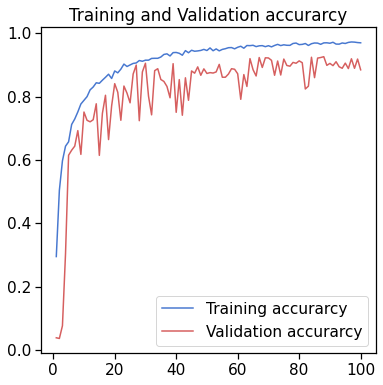

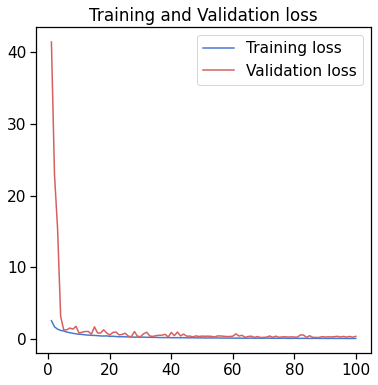

In [0]:
plot_accuracy(col)
plot_loss(col)

In [0]:
#saving the training and validation loss and accuracy
train_loss_col = col.history['loss']
train_acc_col = col.history['accuracy']
val_loss_col = col.history['val_loss']
val_acc_col = col.history['val_accuracy']
save_data(train_loss_col, "train_loss_col")
save_data(train_acc_col, "train_acc_col")
save_data(val_loss_col, "val_loss_col")
save_data(val_acc_col, "val_acc_col")
#saving the model
savepath = os.path.join('.', 'model_col_new.h5')
model.save(savepath)

from google.colab import files
files.download('train_loss_col.txt') 
files.download('train_acc_col.txt') 
files.download('val_loss_col.txt') 
files.download('val_acc_col.txt') 
files.download('model_col_new.h5') 

In [0]:
opt = Adam(lr=INIT_LR, decay=0.001)
# distribution
model_2.compile(loss="categorical_crossentropy", optimizer=opt,\
              metrics=['accuracy'])

# train the network
col_2 = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_val, y_val),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS , verbose=1
    ) 


Epoch 1/100
165/165 [==============================] - 82s 497ms/step - loss: 2.4765 - accuracy: 0.3257 - val_loss: 41.4024 - val_accuracy: 0.0282
Epoch 2/100
165/165 [==============================] - 77s 466ms/step - loss: 1.6877 - accuracy: 0.5139 - val_loss: 8.4810 - val_accuracy: 0.0437
Epoch 3/100
165/165 [==============================] - 76s 459ms/step - loss: 1.3440 - accuracy: 0.6007 - val_loss: 5.4255 - val_accuracy: 0.0847
Epoch 4/100
165/165 [==============================] - 75s 457ms/step - loss: 1.1336 - accuracy: 0.6610 - val_loss: 1.5151 - val_accuracy: 0.5530
Epoch 5/100
165/165 [==============================] - 75s 453ms/step - loss: 0.9690 - accuracy: 0.7143 - val_loss: 1.1179 - val_accuracy: 0.6756
Epoch 6/100
165/165 [==============================] - 75s 456ms/step - loss: 0.9877 - accuracy: 0.6960 - val_loss: 0.8737 - val_accuracy: 0.7440
Epoch 7/100
165/165 [==============================] - 75s 454ms/step - loss: 0.8066 - accuracy: 0.7549 - val_loss: 0.7838 

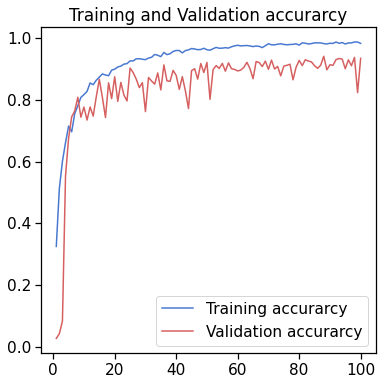

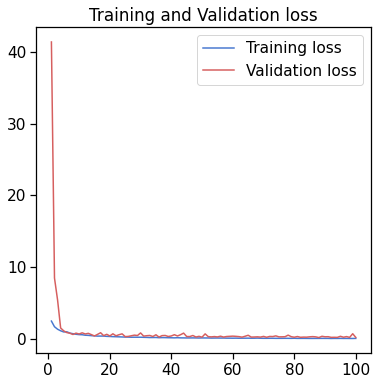

In [0]:
plot_accuracy(col_2)
plot_loss(col_2)

In [0]:
#saving the training and validation loss and accuracy
train_loss_col_2 = col_2.history['loss']
train_acc_col_2 = col_2.history['accuracy']
val_loss_col_2 = col_2.history['val_loss']
val_acc_col_2 = col_2.history['val_accuracy']
save_data(train_loss_col_2, "train_loss_col_2")
save_data(train_acc_col_2, "train_acc_col_2")
save_data(val_loss_col_2, "val_loss_col_2")
save_data(val_acc_col_2, "val_acc_col_2")
#saving the model
savepath = os.path.join('.', 'model_2.h5')
model_2.save(savepath)

**Training different decay rates**

*decay = 0.0001*

In [0]:
opt = Adam(lr=INIT_LR, decay=0.0001)
# distribution
model_2.compile(loss="categorical_crossentropy", optimizer=opt,\
              metrics=['accuracy'])

# train the network
col_dec = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_val, y_val),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS , verbose=0
    ) 


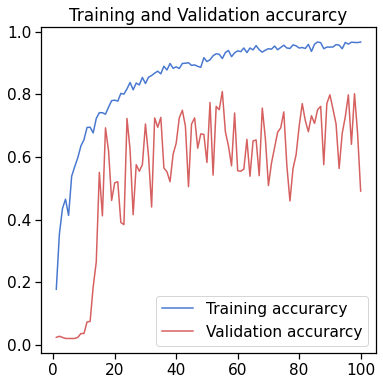

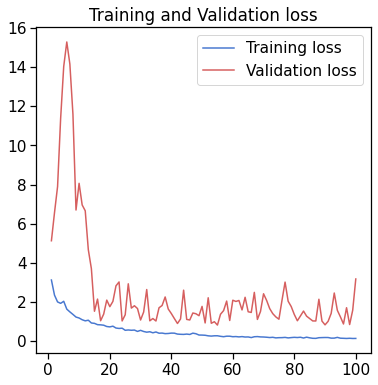

In [0]:
plot_accuracy(col_dec)
plot_loss(col_dec)

In [0]:
train_loss_col_dec = col_dec.history['loss']
train_acc_col_dec = col_dec.history['accuracy']
val_loss_col_dec = col_dec.history['val_loss']
val_acc_col_dec = col_dec.history['val_accuracy']
save_data(train_loss_col_dec, "train_loss_col_dec")
save_data(train_acc_col_dec, "train_acc_col_dec")
save_data(val_loss_col_dec, "val_loss_col_dec")
save_data(val_acc_col_dec, "val_acc_col_dec")

*decay = 0.01*

In [0]:
opt = Adam(lr=INIT_LR, decay=0.01)
# distribution
model_2.compile(loss="categorical_crossentropy", optimizer=opt,\
              metrics=['accuracy'])

# train the network
col_dec2 = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_val, y_val),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS , verbose=0
    ) 


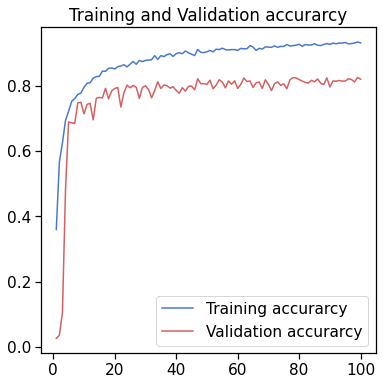

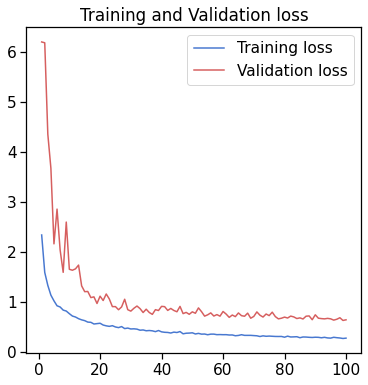

In [0]:
plot_accuracy(col_dec2)
plot_loss(col_dec2)

In [0]:
train_loss_col_dec2 = col_dec2.history['loss']
train_acc_col_dec2 = col_dec2.history['accuracy']
val_loss_col_dec2 = col_dec2.history['val_loss']
val_acc_col_dec2 = col_dec2.history['val_accuracy']
save_data(train_loss_col_dec2, "train_loss_col_dec2")
save_data(train_acc_col_dec2, "train_acc_col_dec2")
save_data(val_loss_col_dec2, "val_loss_col_dec2")
save_data(val_acc_col_dec2, "val_acc_col_dec2")

**Testing**

In [0]:
#testing Model 1
#Reading in testing data
col_image_test_list, col_label_test_list = get_img_label(data_dir_col, -50, 0)
col_image_test_labels, col_label_test_binarizer = transform_labels(col_label_test_list)
x_test, y_test = col_image_test_list, col_image_test_labels

In [0]:
get_classification_report(model, col_label_test_binarizer, x_test, y_test)

1900/1900 [==============================] - 14s 7ms/step
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.64      1.00      0.78        32
                                 Apple___Black_rot       1.00      0.89      0.94        56
                          Apple___Cedar_apple_rust       0.94      0.80      0.86        59
                                   Apple___healthy       0.90      0.94      0.92        48
                               Blueberry___healthy       0.92      0.94      0.93        49
          Cherry_(including_sour)___Powdery_mildew       0.92      0.79      0.85        58
                 Cherry_(including_sour)___healthy       0.96      0.86      0.91        56
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.98      0.82      0.89        60
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00        50
               Corn_(

In [0]:
#Testing Model 2
get_classification_report(model_2, col_label_test_binarizer, x_test, y_test)

1900/1900 [==============================] - 8s 4ms/step
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.94      1.00      0.97        47
                                 Apple___Black_rot       1.00      0.96      0.98        52
                          Apple___Cedar_apple_rust       1.00      0.98      0.99        51
                                   Apple___healthy       1.00      0.79      0.88        63
                               Blueberry___healthy       0.98      1.00      0.99        49
          Cherry_(including_sour)___Powdery_mildew       0.98      1.00      0.99        49
                 Cherry_(including_sour)___healthy       0.96      0.98      0.97        49
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.80      0.87      0.83        46
                       Corn_(maize)___Common_rust_       0.98      1.00      0.99        49
               Corn_(m

**Training network on Black and White dataset**

In [0]:
#reading in training data
BW_image_list, BW_label_list = get_img_label(data_dir_BW, 200, 1)
BW_image_labels, BW_label_binarizer = transform_labels(BW_label_list)
x_train, x_val, y_train, y_val = train_test_split(BW_image_list, BW_image_labels, test_size=0.3, random_state = 42)
n_classes = len(BW_label_binarizer.classes_) 

In [0]:
#same as model 1 but with depth = 1
BW_model = Sequential()
inputShape = (height, width, depth_BW)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth_BW, height, width)
    chanDim = 1

BW_model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
BW_model.add(Activation("relu"))
BW_model.add(BatchNormalization(axis=chanDim))
BW_model.add(Dropout(0.25))
BW_model.add(Conv2D(64, (3, 3), padding="same"))
BW_model.add(Activation("relu"))
BW_model.add(BatchNormalization(axis=chanDim))
BW_model.add(MaxPooling2D(pool_size=(3, 3)))
BW_model.add(Dropout(0.25))
BW_model.add(Conv2D(128, (3, 3), padding="same"))
BW_model.add(Activation("relu"))
BW_model.add(BatchNormalization(axis=chanDim))
BW_model.add(MaxPooling2D(pool_size=(2, 2)))	
BW_model.add(Dropout(0.5))
BW_model.add(Flatten())
BW_model.add(Dense(128))
BW_model.add(Activation("relu"))
BW_model.add(BatchNormalization())
BW_model.add(Dropout(0.3))
BW_model.add(Dense(n_classes))
BW_model.add(Activation("softmax"))

In [0]:
#same as model 2 but with depth = 1
BW_model_2 = Sequential()
inputShape = (height, width, depth_BW)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth_BW, height, width)
    chanDim = 1

BW_model_2.add(Conv2D(64, (3, 3), padding="same",input_shape=inputShape))
BW_model_2.add(Activation("relu"))
BW_model_2.add(BatchNormalization(axis=chanDim))
BW_model_2.add(Dropout(0.25))
BW_model_2.add(Conv2D(64, (3, 3), padding="same"))
BW_model_2.add(Activation("relu"))
BW_model_2.add(BatchNormalization(axis=chanDim))
BW_model_2.add(MaxPooling2D(pool_size=(3, 3)))
BW_model_2.add(Dropout(0.25))
BW_model_2.add(Conv2D(128, (3, 3), padding="same"))
BW_model_2.add(Activation("relu"))
BW_model_2.add(BatchNormalization(axis=chanDim))
BW_model_2.add(Dropout(0.25))
BW_model_2.add(Conv2D(128, (3, 3), padding="same")) 
BW_model_2.add(Activation("relu"))
BW_model_2.add(BatchNormalization(axis=chanDim))
BW_model_2.add(Conv2D(128, (3, 3), padding="same"))
BW_model_2.add(Activation("relu"))
BW_model_2.add(BatchNormalization(axis=chanDim))
BW_model_2.add(MaxPooling2D(pool_size=(2, 2)))
BW_model_2.add(Dropout(0.5))
BW_model_2.add(Flatten())
BW_model_2.add(Dense(128))
BW_model_2.add(Activation("relu"))
BW_model_2.add(BatchNormalization())
BW_model_2.add(Dropout(0.3))
BW_model_2.add(Dense(n_classes))
BW_model_2.add(Activation("softmax"))

In [0]:
#Runnung Model 1
opt = Adam(lr=INIT_LR, decay=0.001)

BW_model.compile(loss="categorical_crossentropy", optimizer=opt,\
              metrics=['accuracy'])

# train the network
BW = BW_model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_val, y_val),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS , verbose=1
    ) 

Epoch 1/100
165/165 [==============================] - 50s 300ms/step - loss: 3.0703 - accuracy: 0.2021 - val_loss: 6.4082 - val_accuracy: 0.0366
Epoch 2/100
165/165 [==============================] - 42s 253ms/step - loss: 2.5527 - accuracy: 0.3005 - val_loss: 6.5698 - val_accuracy: 0.0468
Epoch 3/100
165/165 [==============================] - 42s 252ms/step - loss: 2.2797 - accuracy: 0.3588 - val_loss: 3.7494 - val_accuracy: 0.1041
Epoch 4/100
165/165 [==============================] - 42s 252ms/step - loss: 2.0706 - accuracy: 0.4094 - val_loss: 2.3834 - val_accuracy: 0.3283
Epoch 5/100
165/165 [==============================] - 42s 253ms/step - loss: 1.8787 - accuracy: 0.4496 - val_loss: 2.3373 - val_accuracy: 0.3530
Epoch 6/100
165/165 [==============================] - 42s 252ms/step - loss: 1.6268 - accuracy: 0.5284 - val_loss: 1.6510 - val_accuracy: 0.5084
Epoch 7/100
165/165 [==============================] - 42s 252ms/step - loss: 1.4653 - accuracy: 0.5662 - val_loss: 1.6935 -

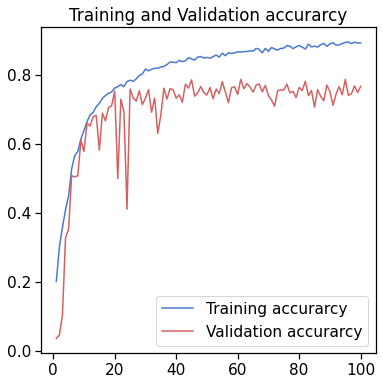

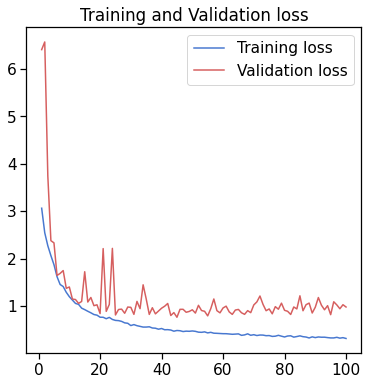

In [0]:
plot_accuracy(BW)
plot_loss(BW)

In [0]:
train_loss_BW = BW.history['loss']
train_acc_BW = BW.history['accuracy']
val_loss_BW = BW.history['val_loss']
val_acc_BW = BW.history['val_accuracy']
save_data(train_loss_BW, "train_loss_BW")
save_data(train_acc_BW, "train_acc_BW")
save_data(val_loss_BW, "val_loss_BW")
save_data(val_acc_BW, "val_acc_BW")
#save the model
savepath = os.path.join('.', 'BW_model_new.h5')
BW_model.save(savepath)

In [0]:
#Running Model 2
opt = Adam(lr=INIT_LR, decay=0.001)

BW_model_2.compile(loss="categorical_crossentropy", optimizer=opt,\
              metrics=['accuracy'])

# train the network
print("[INFO] training network...")
BW_2 = BW_model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_val, y_val),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS , verbose=1
    ) 


[INFO] training network...
Epoch 1/100
165/165 [==============================] - 75s 456ms/step - loss: 3.1328 - accuracy: 0.1747 - val_loss: 8.1116 - val_accuracy: 0.0415
Epoch 2/100
165/165 [==============================] - 66s 401ms/step - loss: 2.5048 - accuracy: 0.3072 - val_loss: 7.9179 - val_accuracy: 0.0269
Epoch 3/100
165/165 [==============================] - 66s 401ms/step - loss: 2.0711 - accuracy: 0.4041 - val_loss: 6.2594 - val_accuracy: 0.0516
Epoch 4/100
165/165 [==============================] - 66s 402ms/step - loss: 1.7869 - accuracy: 0.4892 - val_loss: 3.9768 - val_accuracy: 0.1037
Epoch 5/100
165/165 [==============================] - 67s 403ms/step - loss: 1.5620 - accuracy: 0.5439 - val_loss: 2.0038 - val_accuracy: 0.4113
Epoch 6/100
165/165 [==============================] - 66s 400ms/step - loss: 1.4451 - accuracy: 0.5750 - val_loss: 1.7278 - val_accuracy: 0.4938
Epoch 7/100
165/165 [==============================] - 66s 402ms/step - loss: 1.3002 - accuracy: 

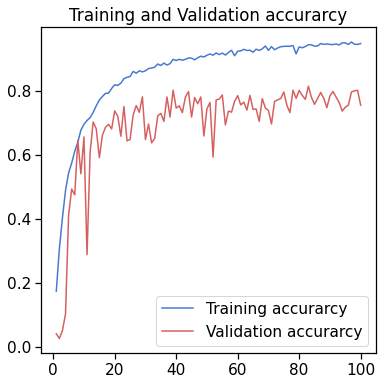

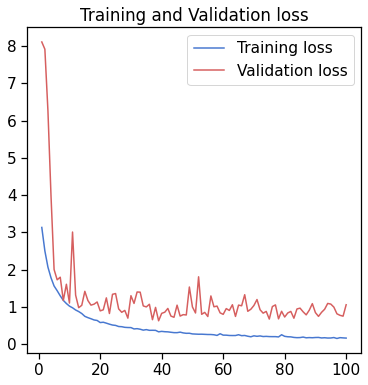

In [0]:
plot_accuracy(BW_2)
plot_loss(BW_2)

In [0]:
train_loss_BW_2 = BW_2.history['loss']
train_acc_BW_2 = BW_2.history['accuracy']
val_loss_BW_2 = BW_2.history['val_loss']
val_acc_BW_2 = BW_2.history['val_accuracy']
save_data(train_loss_BW_2, "train_loss_BW_2")
save_data(train_acc_BW_2, "train_acc_BW_2")
save_data(val_loss_BW_2, "val_loss_BW_2")
save_data(val_acc_BW_2, "val_acc_BW_2")
#save the model
savepath = os.path.join('.', 'BW_model_2.h5')
BW_model_2.save(savepath)

**Training different decay rates**

*decay = 0.0001*

In [0]:
opt = Adam(lr=INIT_LR, decay=0.0001)

BW_model_2.compile(loss="categorical_crossentropy", optimizer=opt,\
              metrics=['accuracy'])

# train the network
BW_dec = BW_model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_val, y_val),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS , verbose=1
    ) 


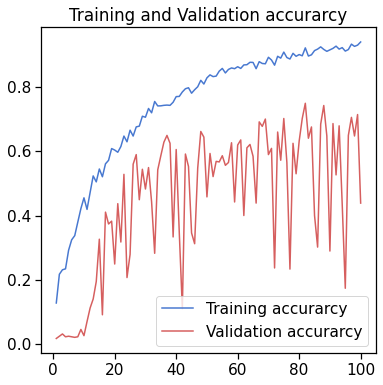

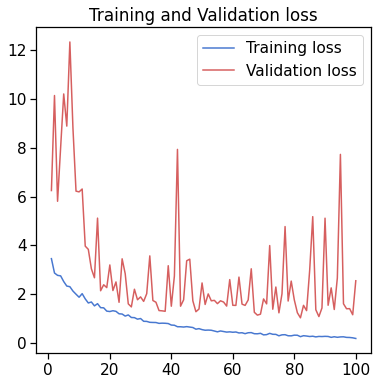

In [0]:
plot_accuracy(BW_dec)
plot_loss(BW_dec)

In [0]:
train_loss_BW_dec = BW_dec.history['loss']
train_acc_BW_dec = BW_dec.history['accuracy']
val_loss_BW_dec = BW_dec.history['val_loss']
val_acc_BW_dec = BW_dec.history['val_accuracy']
save_data(train_loss_BW_dec, "train_loss_BW_dec")
save_data(train_acc_BW_dec, "train_acc_BW_dec")
save_data(val_loss_BW_dec, "val_loss_BW_dec")
save_data(val_acc_BW_dec, "val_acc_BW_dec")

*decay = 0.01*

In [0]:
opt = Adam(lr=INIT_LR, decay=0.01)

BW_model_2.compile(loss="categorical_crossentropy", optimizer=opt,\
              metrics=['accuracy'])

# train the network
BW_dec2 = BW_model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_val, y_val),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS , verbose=0
    ) 

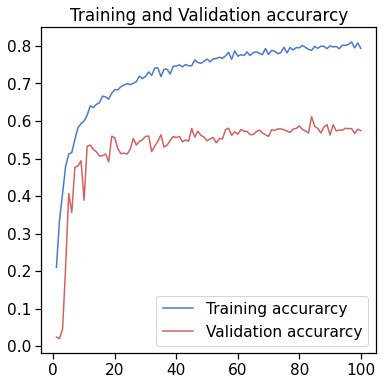

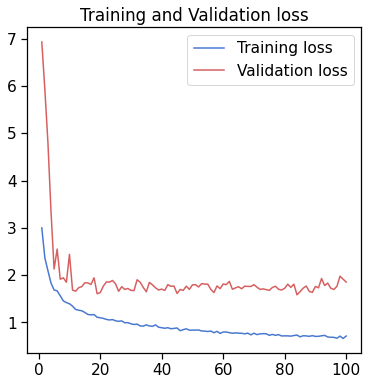

In [0]:
plot_accuracy(BW_dec2)
plot_loss(BW_dec2)

In [0]:
train_loss_BW_dec2 = BW_dec2.history['loss']
train_acc_BW_dec2 = BW_dec2.history['accuracy']
val_loss_BW_dec2 = BW_dec2.history['val_loss']
val_acc_BW_dec2 = BW_dec2.history['val_accuracy']
save_data(train_loss_BW_dec2, "train_loss_BW_dec2")
save_data(train_acc_BW_dec2, "train_acc_BW_dec2")
save_data(val_loss_BW_dec2, "val_loss_BW_dec2")
save_data(val_acc_BW_dec2, "val_acc_BW_dec2")

**Testing**

In [0]:
#reading in testing data 
BW_image_test_list, BW_label_test_list = get_img_label(data_dir_BW, -50, 1)
BW_image_test_labels, BW_label_test_binarizer = transform_labels(BW_label_test_list)
x_test, y_test = BW_image_test_list, BW_image_test_labels

In [0]:
Testing Model 1
get_classification_report(BW_model, BW_label_test_binarizer, x_test, y_test)

1900/1900 [==============================] - 4s 2ms/step
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.62      0.78      0.69        40
                                 Apple___Black_rot       0.84      0.93      0.88        45
                          Apple___Cedar_apple_rust       0.82      0.89      0.85        46
                                   Apple___healthy       0.76      0.78      0.77        49
                               Blueberry___healthy       0.84      0.93      0.88        45
          Cherry_(including_sour)___Powdery_mildew       0.76      0.97      0.85        39
                 Cherry_(including_sour)___healthy       0.90      0.98      0.94        46
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.52      0.76      0.62        34
                       Corn_(maize)___Common_rust_       1.00      0.98      0.99        51
               Corn_(m

In [0]:
#Testing Model 2
get_classification_report(BW_model_2, BW_label_test_binarizer, x_test, y_test)

1900/1900 [==============================] - 6s 3ms/step
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.86      0.90      0.88        48
                                 Apple___Black_rot       0.96      0.73      0.83        66
                          Apple___Cedar_apple_rust       0.92      0.98      0.95        47
                                   Apple___healthy       0.98      0.46      0.62       107
                               Blueberry___healthy       0.94      0.98      0.96        48
          Cherry_(including_sour)___Powdery_mildew       0.92      1.00      0.96        46
                 Cherry_(including_sour)___healthy       0.96      1.00      0.98        48
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.82      0.79      0.80        52
                       Corn_(maize)___Common_rust_       0.92      1.00      0.96        46
               Corn_(m

**Training network on Segmented dataset**

In [0]:
seg_image_list, seg_label_list = get_img_label(data_dir_seg, 200, 0)
seg_image_labels, seg_label_binarizer = transform_labels(seg_label_list)
n_classes = len(seg_label_binarizer.classes_)
x_train, x_val, y_train, y_val = train_test_split(seg_image_list, seg_image_labels, test_size=0.3, random_state = 42) 

In [8]:
#Training Model 1
opt = Adam(lr=INIT_LR, decay=0.001)

model.compile(loss="categorical_crossentropy", optimizer=opt,\
              metrics=['accuracy'])

# train the network
seg = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_val, y_val),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS , verbose=1
    ) 

Epoch 1/100
165/165 [==============================] - 81s 490ms/step - loss: 2.8684 - accuracy: 0.2130 - val_loss: 91.8540 - val_accuracy: 0.0300
Epoch 2/100
165/165 [==============================] - 77s 465ms/step - loss: 2.2505 - accuracy: 0.3573 - val_loss: 28.0611 - val_accuracy: 0.0247
Epoch 3/100
165/165 [==============================] - 77s 467ms/step - loss: 1.9263 - accuracy: 0.4524 - val_loss: 33.0522 - val_accuracy: 0.0296
Epoch 4/100
165/165 [==============================] - 76s 461ms/step - loss: 1.6696 - accuracy: 0.5194 - val_loss: 8.8389 - val_accuracy: 0.0790
Epoch 5/100
165/165 [==============================] - 75s 457ms/step - loss: 1.4325 - accuracy: 0.5820 - val_loss: 3.0574 - val_accuracy: 0.2741
Epoch 6/100
165/165 [==============================] - 75s 456ms/step - loss: 1.3286 - accuracy: 0.6047 - val_loss: 1.9320 - val_accuracy: 0.4550
Epoch 7/100
165/165 [==============================] - 75s 457ms/step - loss: 1.1835 - accuracy: 0.6513 - val_loss: 4.429

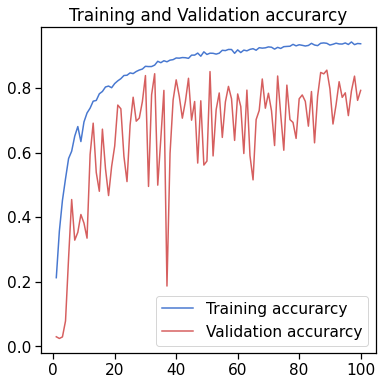

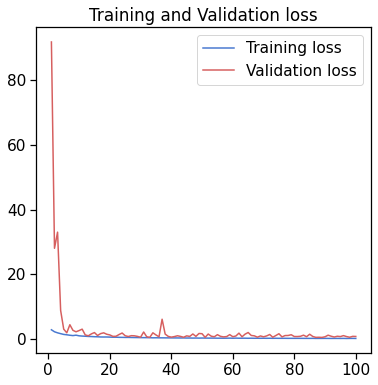

In [11]:
plot_accuracy(seg)
plot_loss(seg)

In [0]:
#saving training and validation loss and accuracy
train_loss_seg = seg.history['loss']
train_acc_seg = seg.history['accuracy']
val_loss_seg = seg.history['val_loss']
val_acc_seg = seg.history['val_accuracy']
save_data(train_loss_seg, "train_loss_seg")
save_data(train_acc_seg, "train_acc_seg")
save_data(val_loss_seg, "val_loss_seg")
save_data(val_acc_seg, "val_acc_seg")
#saving the model
savepath = os.path.join('.', 'model_seg.h5')
model.save(savepath)


In [0]:
#Training Model 2
opt = Adam(lr=INIT_LR, decay=0.001)

model_2.compile(loss="categorical_crossentropy", optimizer=opt,\
              metrics=['accuracy'])

# train the network
print("[INFO] training network...")
seg_2 = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_val, y_val),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS , verbose=1
    ) 

[INFO] training network...
Epoch 1/100
165/165 [==============================] - 83s 504ms/step - loss: 2.8095 - accuracy: 0.2322 - val_loss: 13.8086 - val_accuracy: 0.0269
Epoch 2/100
165/165 [==============================] - 83s 501ms/step - loss: 2.1546 - accuracy: 0.3820 - val_loss: 15.1971 - val_accuracy: 0.0463
Epoch 3/100
165/165 [==============================] - 83s 503ms/step - loss: 1.7860 - accuracy: 0.4793 - val_loss: 10.7127 - val_accuracy: 0.0635
Epoch 4/100
165/165 [==============================] - 83s 501ms/step - loss: 1.9701 - accuracy: 0.4324 - val_loss: 12.0041 - val_accuracy: 0.0905
Epoch 5/100
165/165 [==============================] - 82s 499ms/step - loss: 1.7657 - accuracy: 0.4842 - val_loss: 1.7470 - val_accuracy: 0.4718
Epoch 6/100
165/165 [==============================] - 82s 497ms/step - loss: 1.4439 - accuracy: 0.5737 - val_loss: 4.8444 - val_accuracy: 0.1487
Epoch 7/100
165/165 [==============================] - 82s 497ms/step - loss: 1.2880 - accura

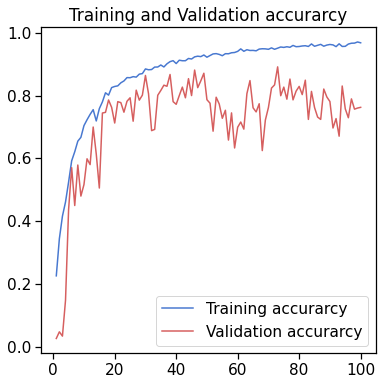

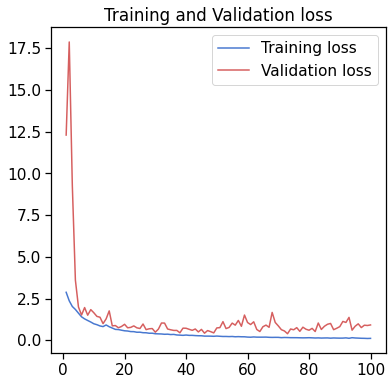

In [0]:
plot_accuracy(seg_2)
plot_loss(seg_2)

In [0]:
#saving training and validation loss and accuracy
train_loss_seg_2 = seg_2.history['loss']
train_acc_seg_2 = seg_2.history['accuracy']
val_loss_seg_2 = seg_2.history['val_loss']
val_acc_seg_2 = seg_2.history['val_accuracy']
save_data(train_loss_seg_2, "train_loss_seg_2")
save_data(train_acc_seg_2, "train_acc_seg_2")
save_data(val_loss_seg_2, "val_loss_seg_2")
save_data(val_acc_seg_2, "val_acc_seg_2")
#saving the model
savepath = os.path.join('.', 'model_2.h5')
model_2.save(savepath)

**Training different decay rates**

*decay = 0.0001*

In [0]:
opt = Adam(lr=INIT_LR, decay=0.0001)

model_2.compile(loss="categorical_crossentropy", optimizer=opt,\
              metrics=['accuracy'])

# train the network
seg_dec = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_val, y_val),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS , verbose=1
    ) 

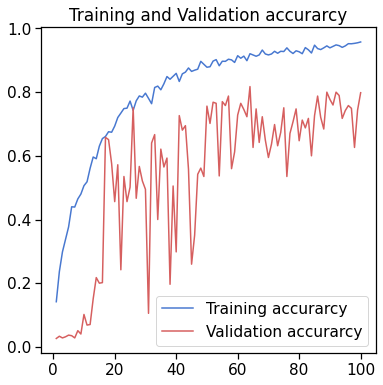

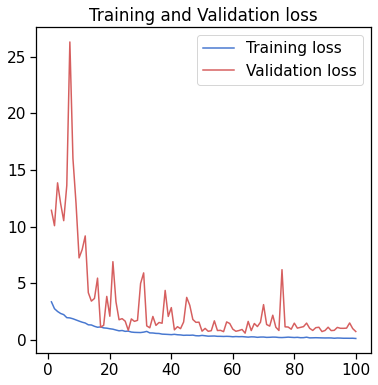

In [0]:
plot_accuracy(seg_dec)
plot_loss(seg_dec)

In [0]:
train_loss_seg_dec = seg_dec.history['loss']
train_acc_seg_dec = seg_dec.history['accuracy']
val_loss_seg_dec = seg_dec.history['val_loss']
val_acc_seg_dec = seg_dec.history['val_accuracy']
save_data(train_loss_seg_dec, "train_loss_seg_dec")
save_data(train_acc_seg_dec, "train_acc_seg_dec")
save_data(val_loss_seg_dec, "val_loss_seg_dec")
save_data(val_acc_seg_dec, "val_acc_seg_dec")

*decay = 0.01*

In [0]:
opt = Adam(lr=INIT_LR, decay=0.01)

model_2.compile(loss="categorical_crossentropy", optimizer=opt,\
              metrics=['accuracy'])

# train the network
seg_dec2 = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_val, y_val),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS , verbose=1
    ) 

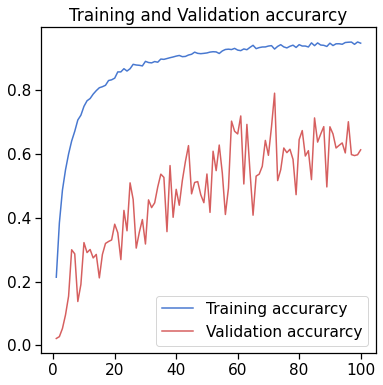

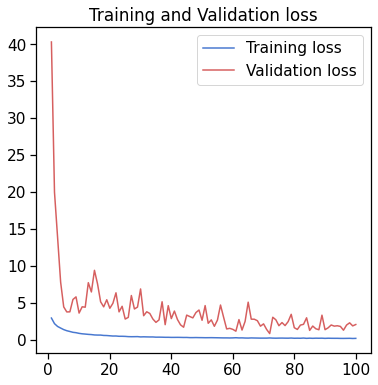

In [0]:
plot_accuracy(seg_dec2)
plot_loss(seg_dec2)

In [0]:
train_loss_seg_dec2 = seg_dec2.history['loss']
train_acc_seg_dec2 = seg_dec2.history['accuracy']
val_loss_seg_dec2 = seg_dec2.history['val_loss']
val_acc_seg_dec2 = seg_dec2.history['val_accuracy']
save_data(train_loss_seg_dec2, "train_loss_seg_dec2")
save_data(train_acc_seg_dec2, "train_acc_seg_dec2")
save_data(val_loss_seg_dec2, "val_loss_seg_dec2")
save_data(val_acc_seg_dec2, "val_acc_seg_dec2")

**Testing**

In [0]:
#reading in testing data 
seg_image_test_list, seg_label_test_list = get_img_label(data_dir_seg, -50, 0)
seg_image_test_labels, seg_label_test_binarizer = transform_labels(seg_label_test_list)
x_test, y_test = seg_image_test_list, seg_image_test_labels

In [13]:
#Testing model 1
get_classification_report(model, seg_label_test_binarizer, x_test, y_test)

1900/1900 [==============================] - 6s 3ms/step
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.88      0.70      0.78        63
                                 Apple___Black_rot       0.98      0.94      0.96        52
                          Apple___Cedar_apple_rust       0.96      1.00      0.98        48
                                   Apple___healthy       0.84      0.91      0.87        46
                               Blueberry___healthy       0.88      0.98      0.93        45
          Cherry_(including_sour)___Powdery_mildew       0.98      0.89      0.93        55
                 Cherry_(including_sour)___healthy       0.68      1.00      0.81        34
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.72      0.88      0.79        41
                       Corn_(maize)___Common_rust_       1.00      0.79      0.88        63
               Corn_(m

In [0]:
#Testing model 2
get_classification_report(model, seg_label_test_binarizer, x_test, y_test)

1900/1900 [==============================] - 8s 4ms/step
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.66      1.00      0.80        33
                                 Apple___Black_rot       0.98      0.96      0.97        51
                          Apple___Cedar_apple_rust       0.70      1.00      0.82        35
                                   Apple___healthy       0.84      0.79      0.82        53
                               Blueberry___healthy       0.92      1.00      0.96        46
          Cherry_(including_sour)___Powdery_mildew       0.88      0.98      0.93        45
                 Cherry_(including_sour)___healthy       0.94      0.96      0.95        49
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.84      0.89      0.87        47
                       Corn_(maize)___Common_rust_       1.00      0.64      0.78        78
               Corn_(m

### V. Results and Conclusion <a id='results'></a>

The three versions of the dataset perform very differently keeping the model architecture and all parameters constant. It is observed that the colored model performs the best with highest accuracy; 93%, using the imporoved model and 88% using the simple model, while the gray scaled dataset performed the least, with 76% accuracy for both models and the performance of the model on the segmented dataset is much better than the gray scaled dataset but less than the colored version with 86% accuracy and 80% for the improved and simple model respectively. 

Other evaluation metrics were used to compare the models' performance on the three datasets: Precision, Recall, and F1 score. The colored dataset achieved the highest percision; 91% and 94% in the simple and imporved models respectively. It also achieved highest recall and F1-scores;  Interestingly, the Black and White dataset doesn't really improve much between the two models and achieve the lowest scores across all datasets; in the simple model it achieved 81% percision and in the improved model it jumped by 2% to reach 83% and for Recall and F1-Score it stays at 76%. As for the color segmented dataset, we still find that it performs better than the Black & White dataset but not as good as the colored one. We obtained 84% and 89% percision for simple and imporoved models respectively, 80% and 86% recall, and 79% and 85% F1-scores. 

In an attempt to answer the research question of this project, does the network learn to extract in depth features about the images or does it get affected by the inherent biases associated with the lighting conditions, colors, and how the data was collected. We can observe that when the network was trained on the gray scaled version of the dataset, the performance of the model decreased compared to the colored versions. The F1 score for the gray scaled version was 76%. This shows that the model wasn’t able to fully adapt given the absence of color from the images, however it was still able to learn deeper level structures of the image, that is able to identify the type of crops and diseases. The segmented dataset gives us an idea of how the background of the image affect the overall performance of the network, it gives lower accuracy and F1 score in both model architectures, than the colored dataset, 80% compared to 88% acuuracy for the simple model and 86% comapred to 93% accuracy for the imporoved model. For the F1-scores, we get 79% compared to 88% (simple model) and 85% compared to 93% (improved model). 

An important observation is that going from a simple model to a more complex model where we increase the number of convolutional layers on the two versions of the colored dataset had a huge impact on the improvement of the model performances, we can notice an average jump of 5% across all the different evaluation metrics for both the colored and segmented dataset. However, when we look at the effect on the Black & White dataset we don't really get any noticebale difference in the model performance.

Observing the results from using different decay rates, we can notice that the a decay rate of 0.0001 produces the most volatility for both training and validation loss and accuracy, this could be due to the fact that the decay is very small, so the learning rate is very high and doesn't go down that quickly, so the model is learning in a faster manner and thus is more volatile. As for the decay rate of 0.01, it could be noticed that the biggest gap between the training and validation accuracy; clearly if we are dropping the learning rate by big values, then the rate will go down really fast and so the model is not going to be able to learn very fast and thus won't pick up the accuracy as it is overfitting. We can also notice that both decay rate produce overall less training and validation accuracy for all versions of the dataset and more loss on average.



**Comparison Graphs**

### Model I Comparison graph

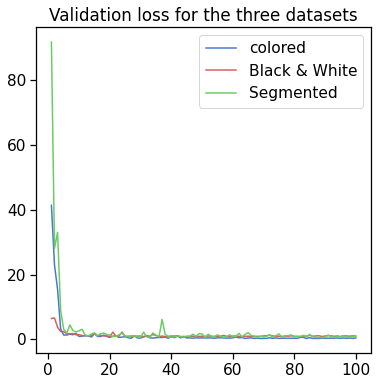

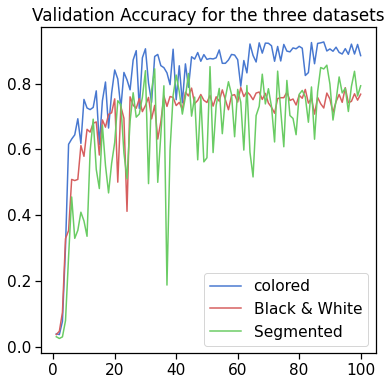

In [10]:
plot_val_loss(col, BW, seg, "Validation loss for the three datasets")
plot_val_acc(col, BW, seg, "Validation loss for the three datasets")

### Model II Comparison Graph

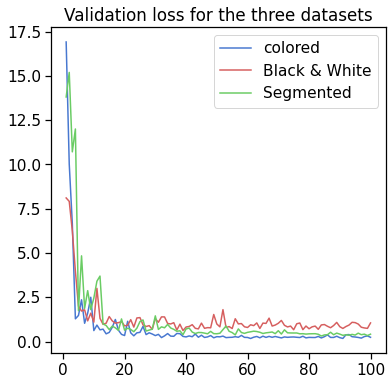

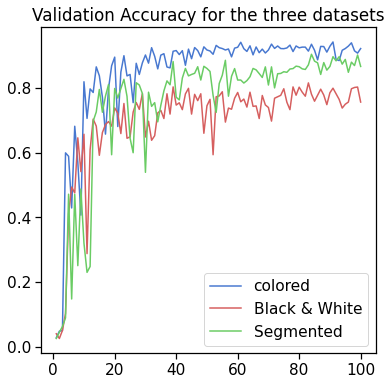

In [0]:
plot_val_loss(col_2, BW_2, seg_2, "Validation loss for the three datasets")
plot_val_acc(col_2, BW_2, seg_2, "Validation loss for the three datasets")

### Comparison Graph for Model II, Decay = 0.0001

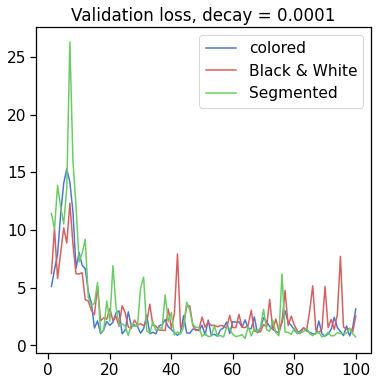

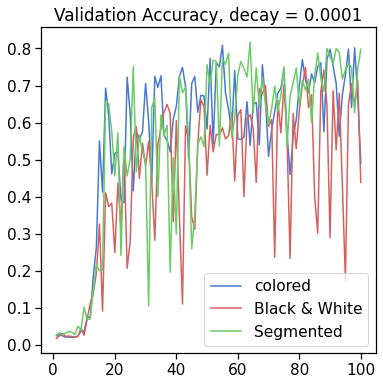

In [0]:
plot_val_loss(col_dec, BW_dec, seg_dec, 'Validation Accuracy, decay = 0.0001')
plot_val_acc(col_dec, BW_dec, seg_dec, 'Validation Accuracy, decay = 0.0001')

### Comparison Graph for Model II, Decay = 0.01

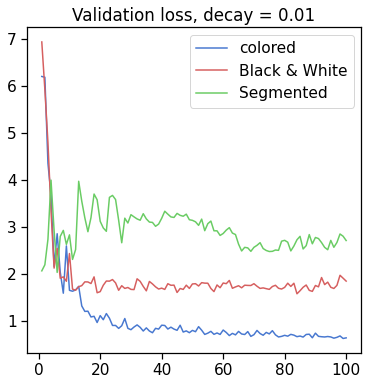

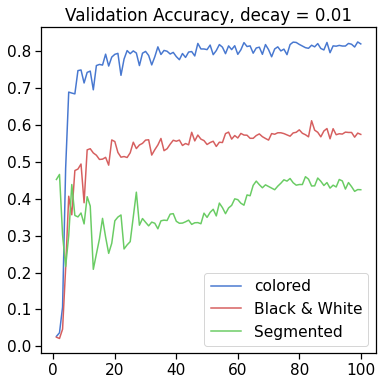

In [0]:
plot_val_loss(col_dec2, BW_dec2, seg_dec2, 'Validation Accuracy, decay = 0.01')
plot_val_acc(col_dec2, BW_dec2, seg_dec2, 'Validation Accuracy, decay = 0.01')

###  References

[1] Goodfellow, Ian, et al. Deep Learning. The MIT Press, 2017.

[2] Glorot, X., Bordes, A. and Bengio, Y., 2011. Deep Sparse Rectifier Neural Networks. Proceedings.mlr.press. Available at: <http://proceedings.mlr.press/v15/glorot11a/glorot11a.pdf>.

[3] Sergey Ioffe and Christian Szegedy (2015). "Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift." 1502.03167, arXiv

[4] Strange, Richard N., and Peter R. Scott. “Plant Disease: A Threat to Global Food Security.” Annual Review of Phytopathology, vol. 43, no. 1, 2005, pp. 83–116., doi:10.1146/annurev.phyto.43.113004.133839.

[5] Xavier Glorot, Antoine Bordes, Yoshua Bengio. "Proceedings of the Fourteenth International Conference on Artificial Intelligence and Statistics", PMLR 15:315-323, 2011.


[6] Krizhevsky, A., Sutskever, I. & Hinton, G. E. (2012). "ImageNet Classification with Deep Convolutional Neural Networks." In F. Pereira, C. J. C. Burges, L. Bottou & K. Q. Weinberger (ed.), Advances in Neural Information Processing Systems 25, pp. 1097--1105

[7] Simonyan, K., Zisserman, A. (2015). "Very Deep Convolutional Networks for Large-Scale Image Recognition". Visual Geometry Group, Department of Engineering Science, University of Oxford, Published as a conference paper at ICLR 2015.